# Model Deployment
Di sesi kali ini kita akan mencoa melakukan simulasi kode untuk deployment. Model akan digunakan untuk melakukan prediksi data yang sebenarnya dari internet. 

In [24]:
import keras
from keras.models import load_model
from keras import preprocessing
import time
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import cv2
import tf2onnx
import onnx
import onnxruntime
import os


## Load Model
Melakukan load model terhadap model yang sudah dilatih sebelumnya

In [2]:
model = load_model("models/inception_v3_epochs_20_input_128x128_relu_512.keras")

Mengubah ke ONNX model untuk test latency

In [3]:
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx_model_path = 'models/inception_v3_epochs_20_input_128x128_relu_512.onnx'
onnx.save(onnx_model, onnx_model_path)


In [4]:
session = onnxruntime.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


## Prediksi wajah tunggal
Melakuakn prediksi terhadap foto yang hanya memiliki satu wajah

In [5]:
def predict_test(img_path, onnx_session=None, plot=True):
    img = preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    start_time = time.time()
    if onnx_session is not None:
        predictions = session.run([output_name], {input_name: img_array})[0]
    else:
        predictions = model.predict(img_array)
    end_time = time.time()
    latency = end_time - start_time
    predicted_class = np.argmax(predictions[0])

    class_labels = ['Female', 'Male']
    label = class_labels[predicted_class]
    conf = predictions[0][predicted_class]
    
    if plot is True:
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        
        plt.imshow(image)
        plt.axis('off') 
        plt.title(img_path)
        plt.text(width//2, height, f'{label}|conf={conf:.4f}|lat={latency:.4f}s', ha='center', va='top', fontsize=18, color='black', bbox=dict(facecolor='yellow', alpha=0.8))
        plt.show()
    return label, conf, latency

1/1 [==============================] - 1s 608ms/step


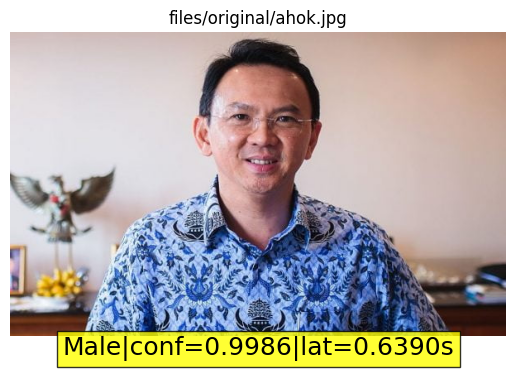

('Male', 0.998599, 0.6390221118927002)

In [6]:
test_results = []
img_path = "files/original/ahok.jpg"
predict_test(img_path)


## Prediksi dengan wajah yang dicrop
Untuk melakukan crop wajah kita memerlukan fungsi untuk mendeteksi wajah dalam foto, ada beberapa pilihan yang tersedia.
Pada awalnya saya menggunakan HAARCASCADE yang tersedia pada opencv, tapi ada banyak kekeliruan dalam deteksi.
    
Kali ini saya akan menggunakan model MTCNN untuk mendapatkan bounding box dari wajah dalam suatu gambar.
Perlu juga dilakukan perbesaran sekala bounding box agar terkapture seluruh bagian kepala. Karena dataset yang digunakan juga mengcapture seluruh kepala

In [7]:
original_dir = "files/original"
cropped_dir = "files/cropped"
detector = MTCNN()

In [8]:
def crop_faces_mtcnn(image_name, scale_factor=1.8):
    path = f"{original_dir}/{image_name}"
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR)
    detections = detector.detect_faces(image)
    min_conf = 0.9
    cropped_files = []
    for i, det in enumerate(detections):
        if det['confidence'] >= min_conf:
            x, y, w, h = det['box']

            scaled_w = int(w * scale_factor)
            scaled_h = int(h * scale_factor * 0.8)
            scaled_x = max(0, x - (scaled_w - w) // 2)
            scaled_y = max(0, y - (scaled_h - h) // 2)
            scaled_w = min(scaled_w, image.shape[1] - scaled_x)
            scaled_h = min(scaled_h, image.shape[0] - scaled_y)

            cropped_face = image[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            cropped = f"cf{i}_{image_name}"
            cv2.imwrite(f"{cropped_dir}/{cropped}", cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))
            cropped_files.append(cropped)
    return cropped_files


## Melakukan crop terhadap wajah dengan MTCNN

In [9]:
filenames = crop_faces_mtcnn("ahok.jpg")


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 26ms/step


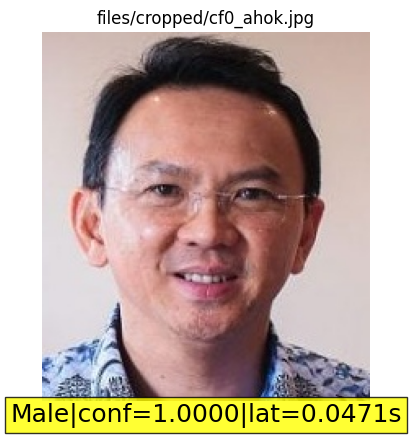

('Male', 0.99999976, 0.04705309867858887)

In [10]:
img_path = f"{cropped_dir}/{filenames[0]}"
predict_test(img_path)

Latency terdapat pengurangan, dan confidence juga mengalami peningkatan

Aspect ratio juga sangat mempengaruhi latency, sebisa mungkin mendekati 1:1

## Menggunakan ONNX Runtime

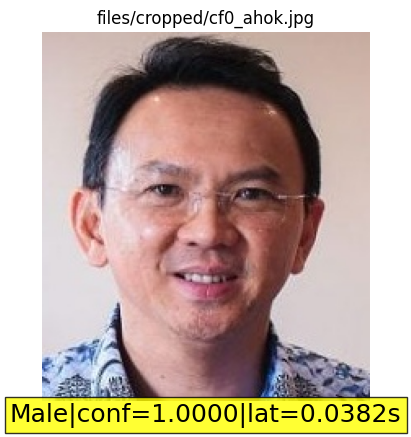

('Male', 0.99999976, 0.03822016716003418)

In [11]:
predict_test(img_path, session)

Latency terdapat pengurangan, namun confidence cenderung tetap


## Visualize side by side

In [12]:
test_sources = [
    {
        "name": "Original",
        "img_path": f"{original_dir}/ahok.jpg",
        "session": None
    },
    {
        "name": "Cropped",
        "img_path": f"{cropped_dir}/{filenames[0]}",
        "session": None
    },
    {
        "name": "ONXX",
        "img_path": f"{cropped_dir}/{filenames[0]}",
        "session": session
    }
]

test_results = []

for source in test_sources:
    label, conf, latency = predict_test(img_path=source["img_path"], onnx_session=source["session"], plot=False)
    print(conf, latency)
    test_results.append({
        "name": source["name"],
        "conf": conf,
        "latency": latency
    })

1/1 [==============================] - 0s 34ms/step
0.998599 0.06682801246643066
1/1 [==============================] - 0s 32ms/step
0.99999976 0.06162905693054199
0.99999976 0.01536417007446289


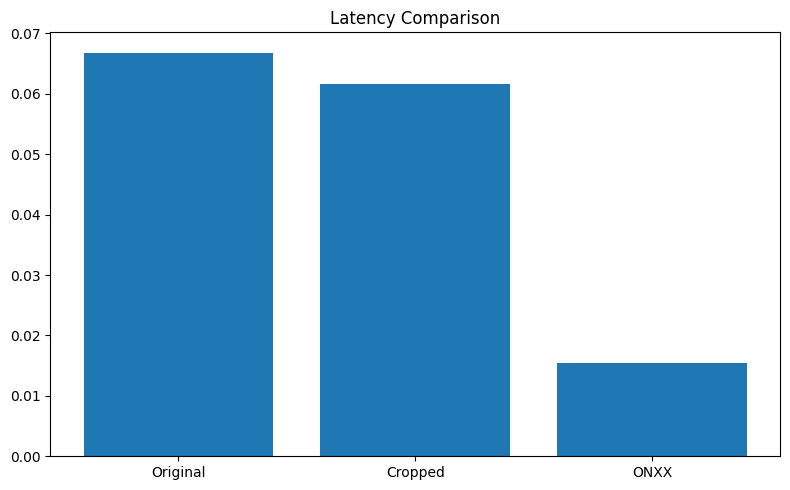

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
latencies= [x['latency'] for x in test_results]
names = [f"{x['name']}" for x in test_results]

# Plot the data as a bar chart
ax.bar(names, latencies)
# Add labels and title
ax.set_title('Latency Comparison')
plt.tight_layout()
plt.show()

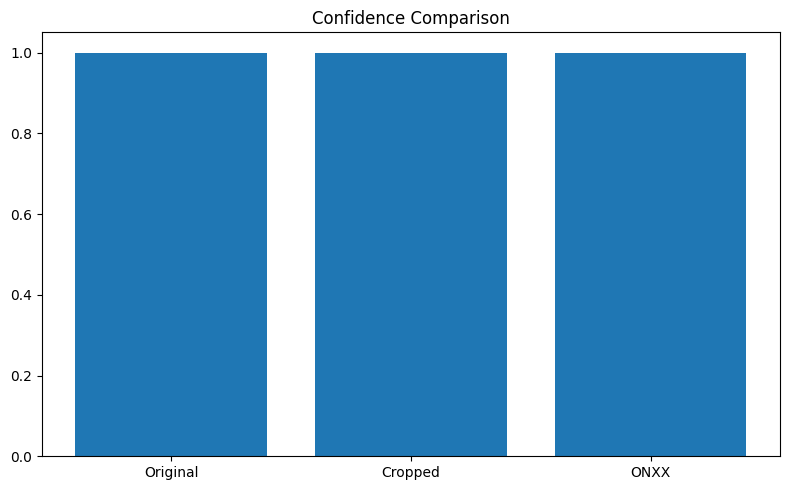

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
confidences= [x['conf'] for x in test_results]
names = [f"{x['name']}" for x in test_results]

# Plot the data as a bar chart
ax.bar(names, confidences)
# Add labels and title
ax.set_title('Confidence Comparison')
plt.tight_layout()
plt.show()

## Prediksi dengan banyak wajah dalam foto
Kali ini kita akan melakukan crop untuk setiap wajah foto yang ditemukan dalam gambar dan melakukan prediksi untuk masing-masing wajah

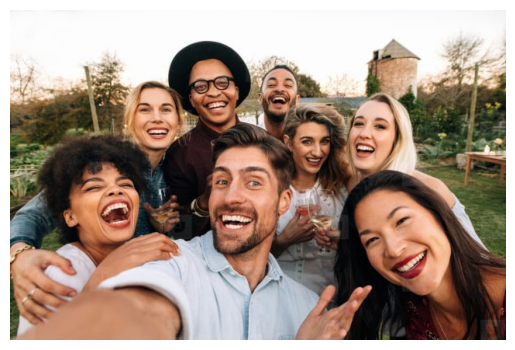

In [15]:
image_name = "foto_grup.jpg"
img_path = f"{original_dir}/{image_name}"

original = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
plt.imshow(original)
plt.axis('off') 
plt.show()

## Melakukan crop terhadap masing-masing wajah

In [16]:
filenames = crop_faces_mtcnn("foto_grup.jpg")
print(filenames)

3/3 [==============================] - 0s 6ms/step
['cf0_foto_grup.jpg', 'cf1_foto_grup.jpg', 'cf2_foto_grup.jpg', 'cf3_foto_grup.jpg', 'cf4_foto_grup.jpg', 'cf5_foto_grup.jpg', 'cf6_foto_grup.jpg', 'cf7_foto_grup.jpg']


## Visualisasi hasil prediksi

In [17]:
def plot_results(data):
    num_columns = 3
    num_rows = int(np.ceil(len(data) / num_columns))
    
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))
    
    for i, face in enumerate(data):
        img = cv2.cvtColor(cv2.imread(face["path"]), cv2.COLOR_RGB2BGR)
        
        ax = axs[i // num_columns, i % num_columns]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(face["path"])
        ax.text(0.5, 0.2, f'{face["label"]} | conf: {face["conf"]:.4} ', transform=ax.transAxes, ha='center', va='top', fontsize=20, color='black', bbox=dict(facecolor='yellow', alpha=0.8))
        ax.text(0.5, 0.1, f'lat: {face["latency"]:.4}s', transform=ax.transAxes, ha='center', va='top', fontsize=18, color='white', bbox=dict(facecolor='blue', alpha=0.8))
    
    for i in range(len(data), num_rows*num_columns):
        fig.delaxes(axs.flatten()[i])
    
    plt.tight_layout()
    plt.show()
    


In [18]:
def show_latency(data):
    total_latency = sum(x['latency'] for x in data)
    len_data = len(data)
    print(f"Average latency: {total_latency / len_data}")
    min_latency = np.array([x['latency'] for x in data])
    print(f"Minimum latency: {np.amin(min_latency)}")
    print(f"Maximum latency: {np.amax(min_latency)}")

## Menggunakan Keras Model

1/1 [==============================] - 0s 23ms/step


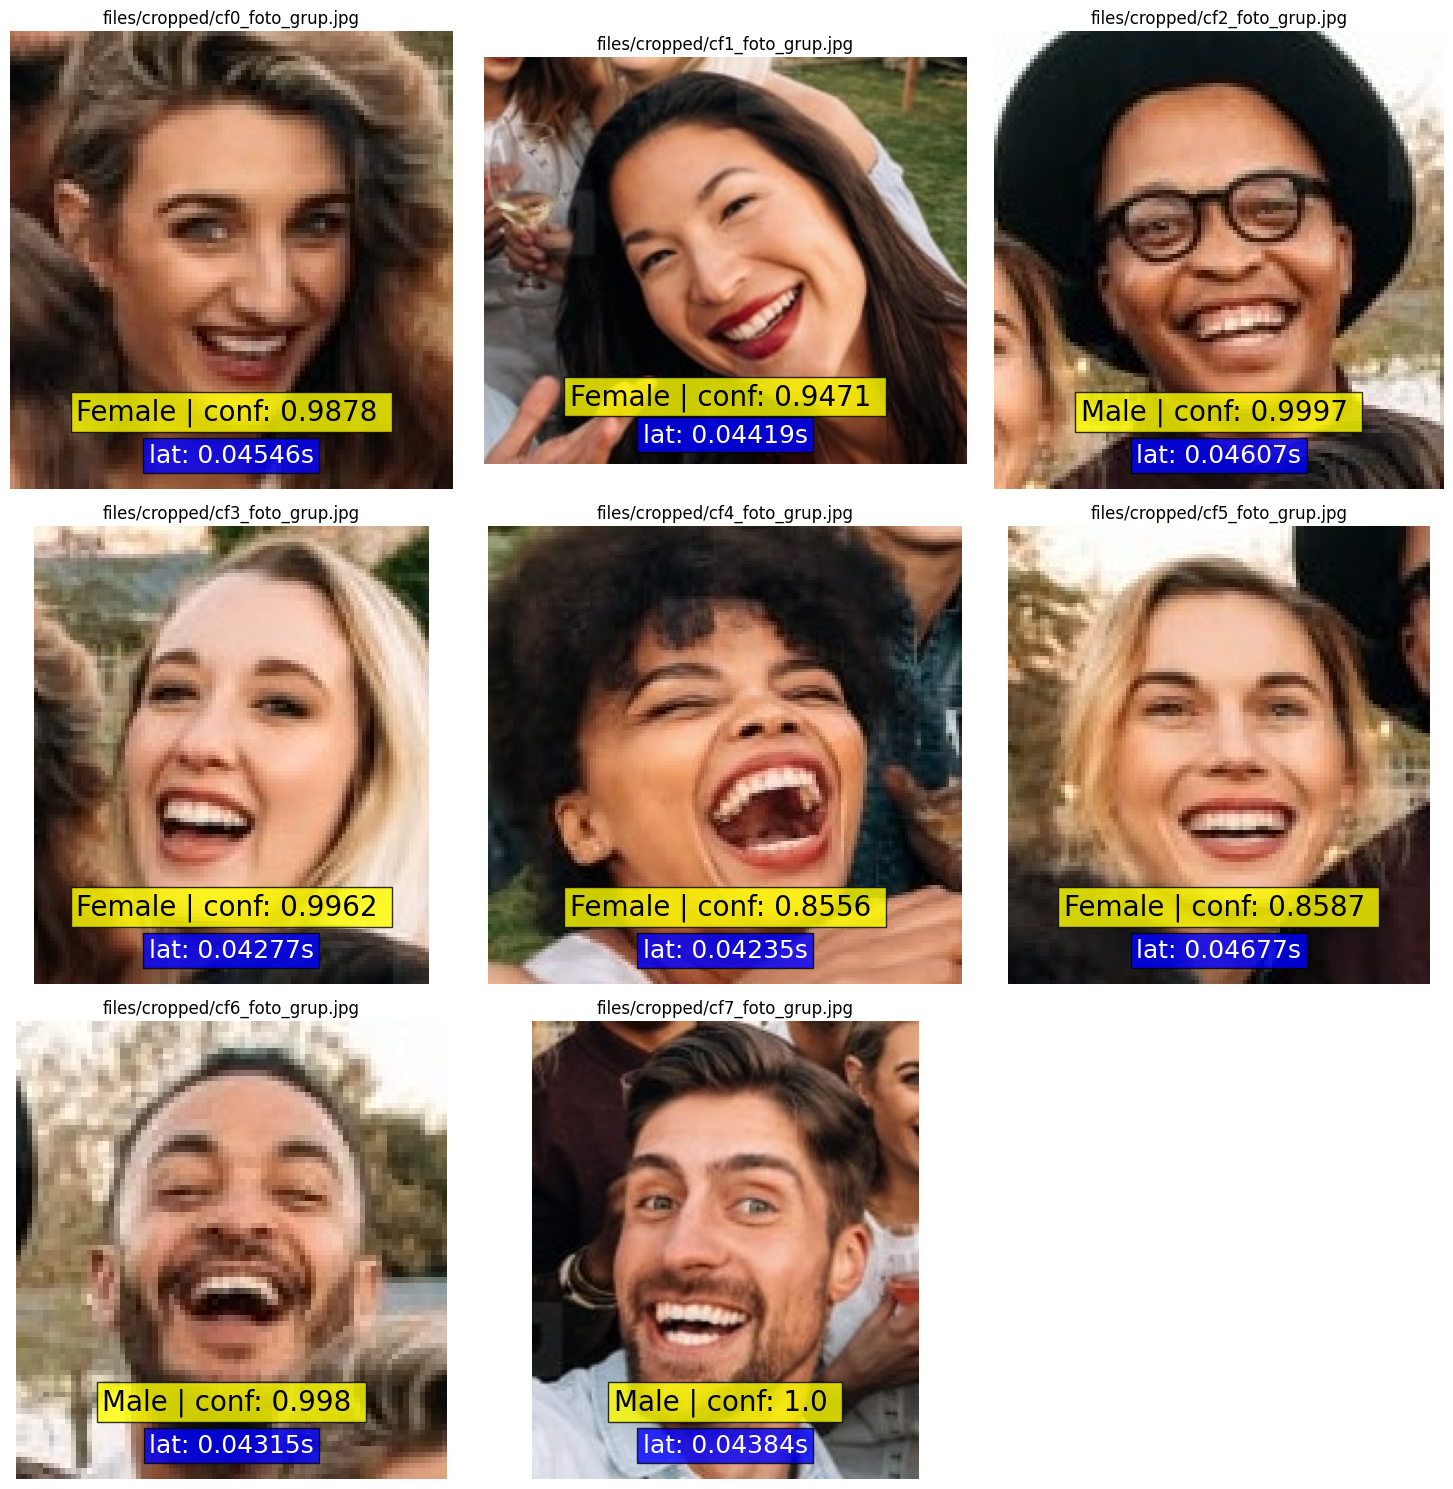

Average latency: 0.04432535171508789
Minimum latency: 0.042351722717285156
Maximum latency: 0.04677295684814453


In [19]:
results = []
for filename in filenames:
    path = f'{cropped_dir}/{filename}'
    label, conf, latency = predict_test(path, plot=False)
    results.append({
        "path": path,
        "label": label,
        "conf": conf,
        "latency": latency
    })
plot_results(results)
show_latency(results)

## Menggunakan ONNX Model

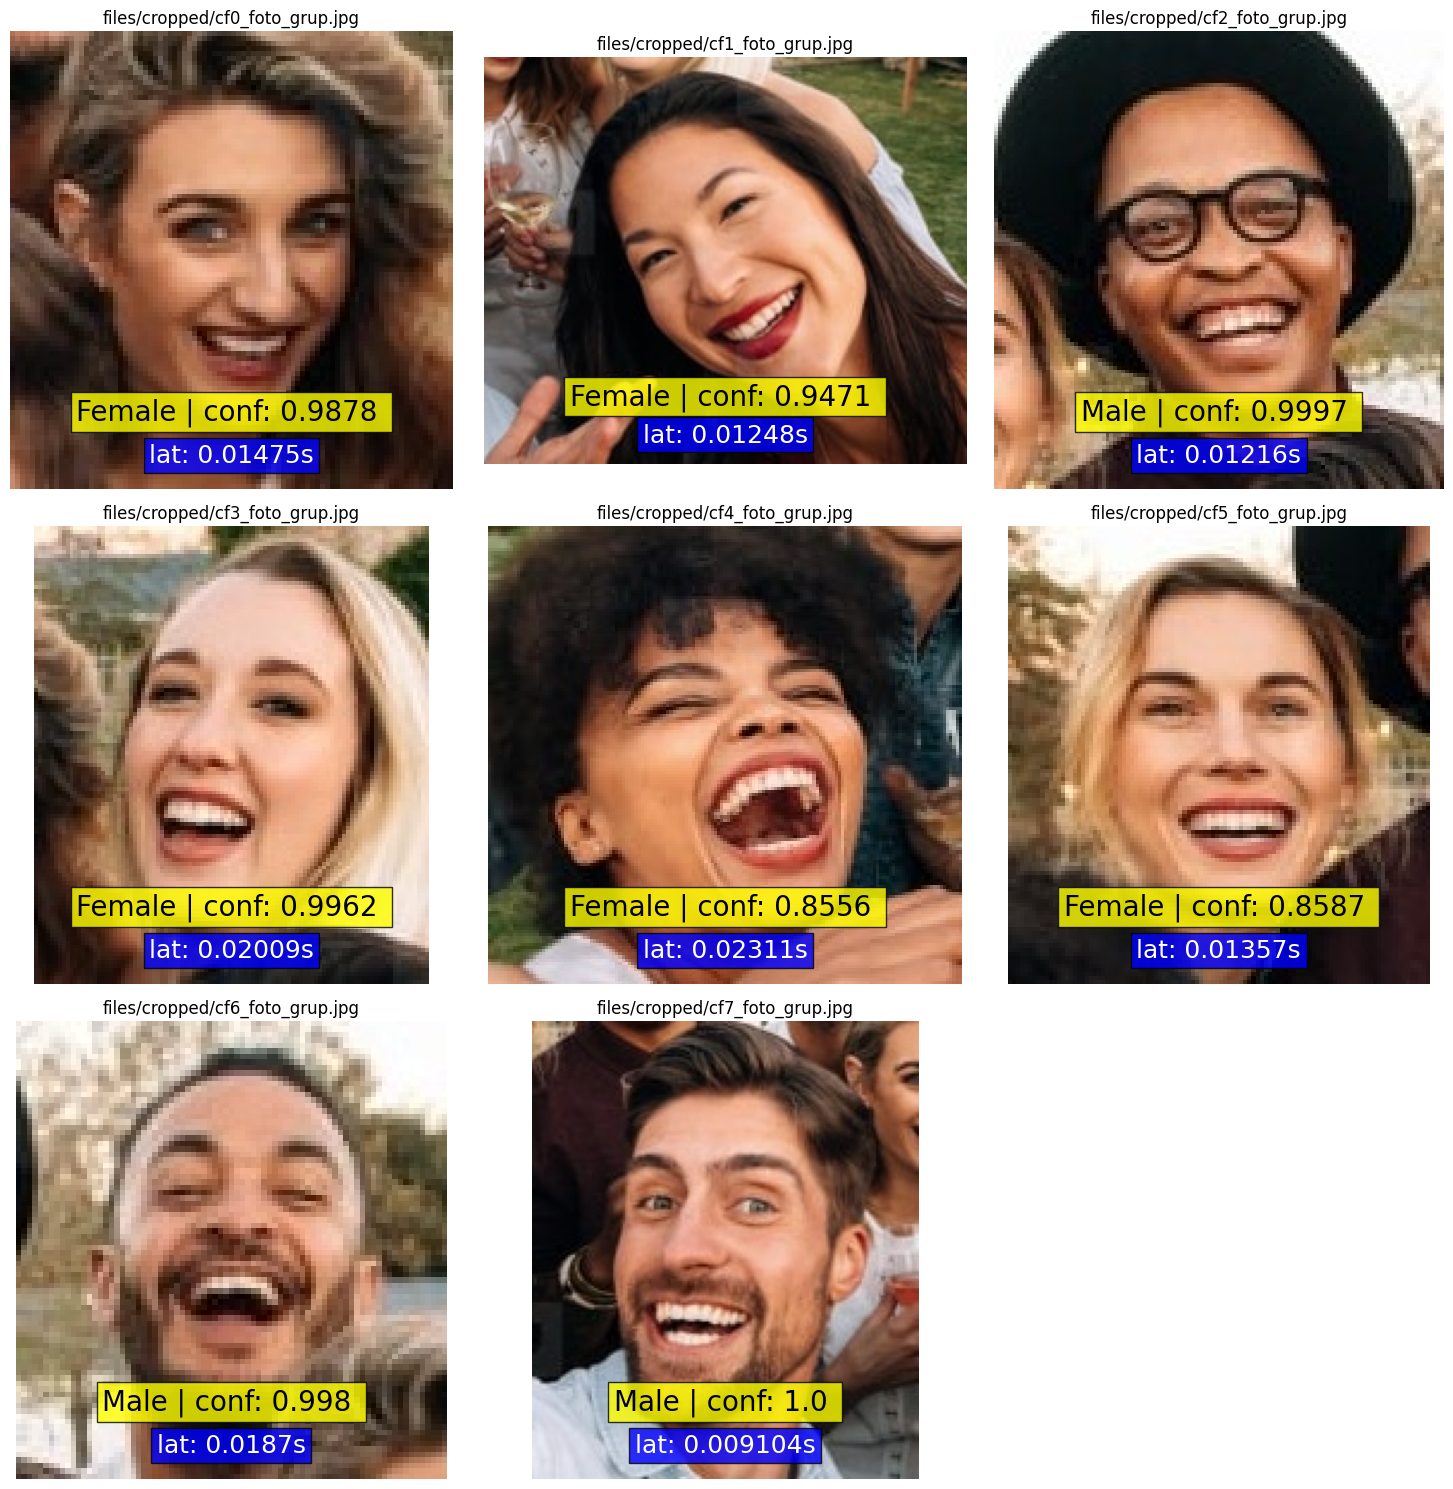

Average latency: 0.015496134757995605
Minimum latency: 0.009104013442993164
Maximum latency: 0.023111820220947266


In [20]:
results = []
for filename in filenames:
    path = f'{cropped_dir}/{filename}'
    label, conf, latency = predict_test(path, onnx_session=session, plot=False)
    results.append({
        "path": path,
        "label": label,
        "conf": conf,
        "latency": latency
    })
plot_results(results)
show_latency(results)

## Prediksi wajah pada video

Spesifikasi hardware:
Mac mini m1 2020, 16GB RAM.

Dengan melakukan skip 5 frame mendapatkan kurang lebih 28 FPS,  dan dalam 1 detik bisa menjalankan minimal 5-6x prediction (PPS). Sedangkan latensi stabil di 0.01s menggunakan model format onnx. 
Tingkat konfidensi dalam menebak menjadi sedikit kurang stabil, tetapi latency menjadi sangat kecil. Perlu tuning model untuk meningkatkan konfiden dengan mempertahankan latency yang kecil.

ref video: inceptionv3_epoch_20_input_128_relu_512.mp4

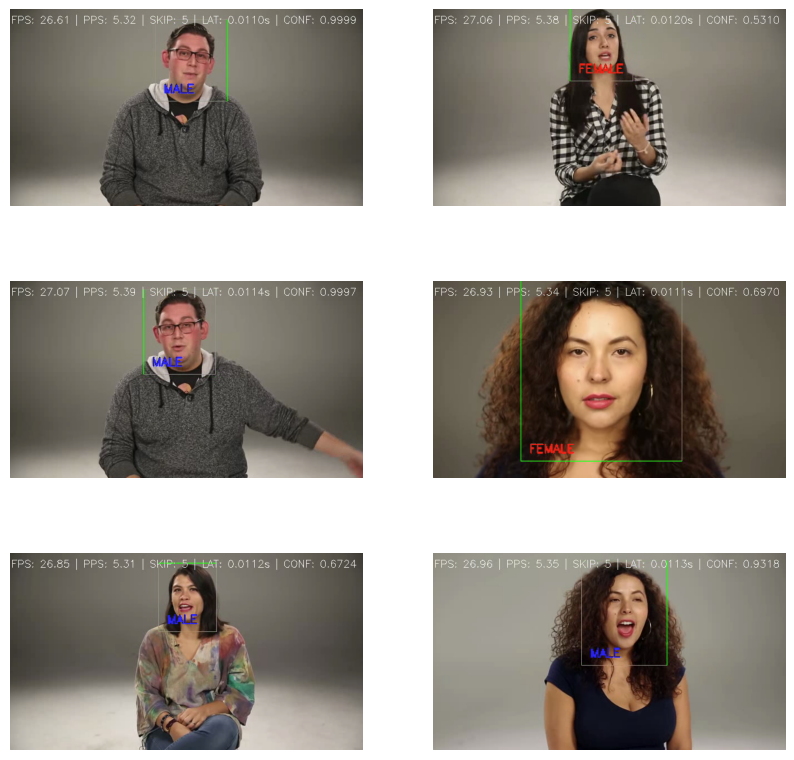

In [25]:
ss_dir = "files/ss2"
image_files = os.listdir(ss_dir)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < len(image_files):
        image_file = image_files[i]
        img = cv2.imread(f'{ss_dir}/{image_file}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        ax.imshow(img)
        ax.axis('off')

plt.show()

## Web Deployment
Backend menggunakan FastAPI dan frontend menggunakan NextJS, serta model yang dipakai adalah versi ONNX

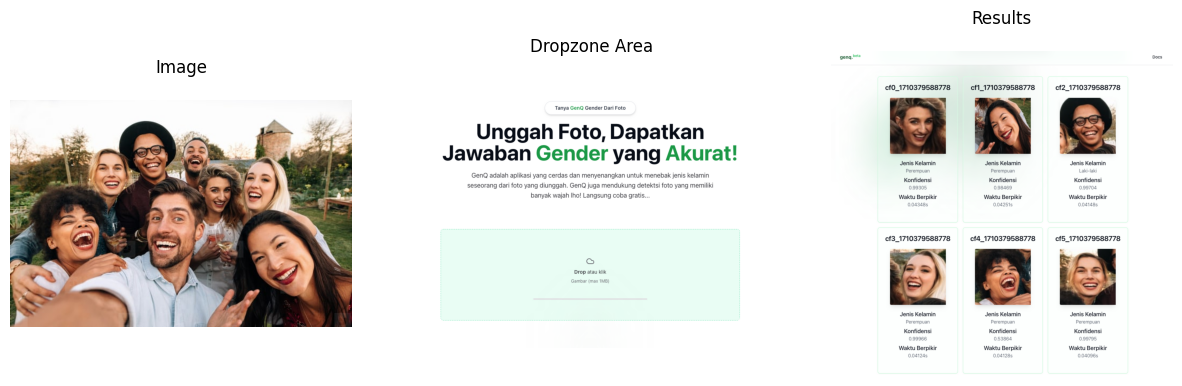

In [21]:
web1 = cv2.cvtColor(cv2.imread("files/original/foto_grup.jpg"), cv2.COLOR_BGR2RGB)
web2 = cv2.cvtColor(cv2.imread("files/web.png"), cv2.COLOR_BGR2RGB)
web3 = cv2.cvtColor(cv2.imread("files/web-result.png"), cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(web1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Image', pad=20, loc='center')

axs[1].imshow(web2, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Dropzone Area', pad=20, loc='center')


axs[2].imshow(web3, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Results', pad=20, loc='center')

# Show the plot
plt.show()